Number of categories: 8
               categories number of files
0      dyed-lifted-polyps            1000
1  dyed-resection-margins            1000
2             esophagitis            1000
3            normal-cecum            1000
4          normal-pylorus            1000
5           normal-z-line            1000
6                  polyps            1000
7      ulcerative-colitis            1000
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.3663 - loss: 4.6106 - val_accuracy: 0.7188 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.6936 - loss: 0.8318 - val_accuracy: 0.7563 - val_loss: 0.6058 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.7662 - loss: 0.5825 - val_accuracy: 0.7859 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.8165 - loss: 0.4541 - val_accuracy: 0.8010 - val_loss: 0.5010 - learning_ra

Final Training Accuracy: 96.29%
Final Validation Accuracy: 81.98%
Test Accuracy: 79.12%
Validation Loss: 0.514
Validation Accuracy: 81.98 %
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Precision: 0.7907210097170867
Recall: 0.79125
F1-Score: 0.7909105743208198


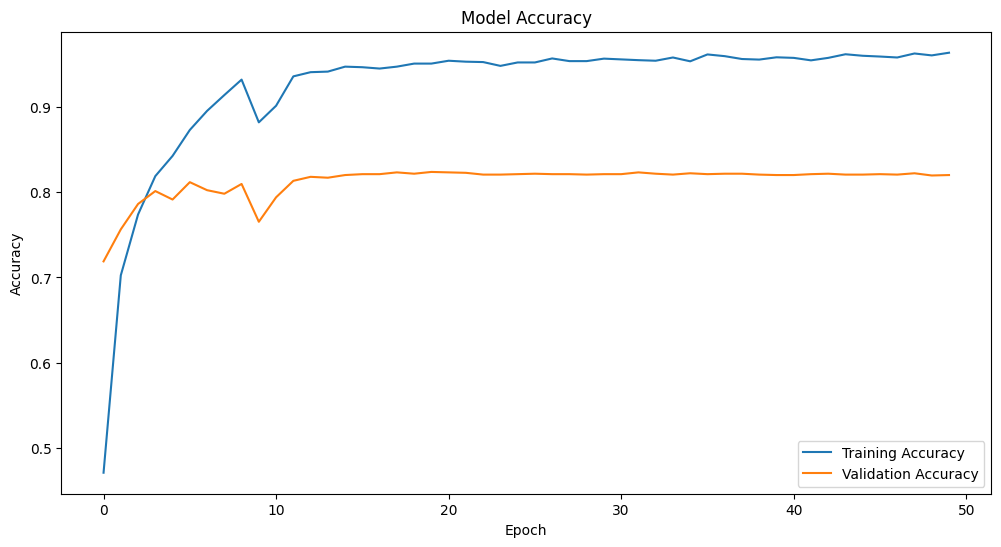

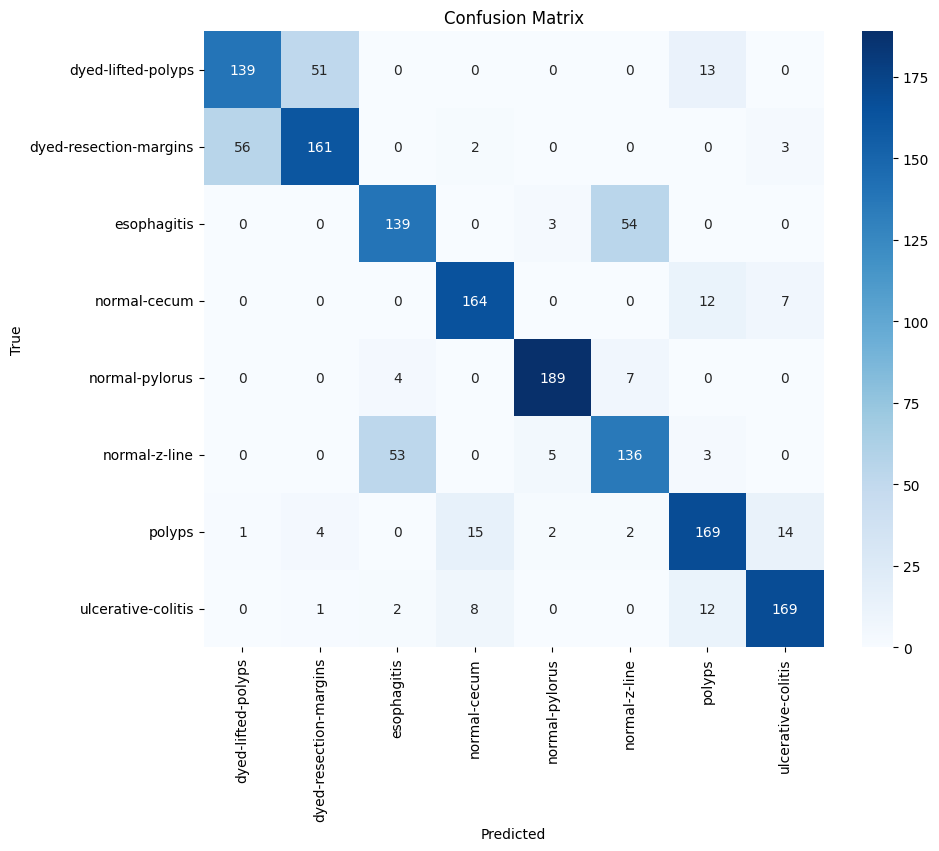

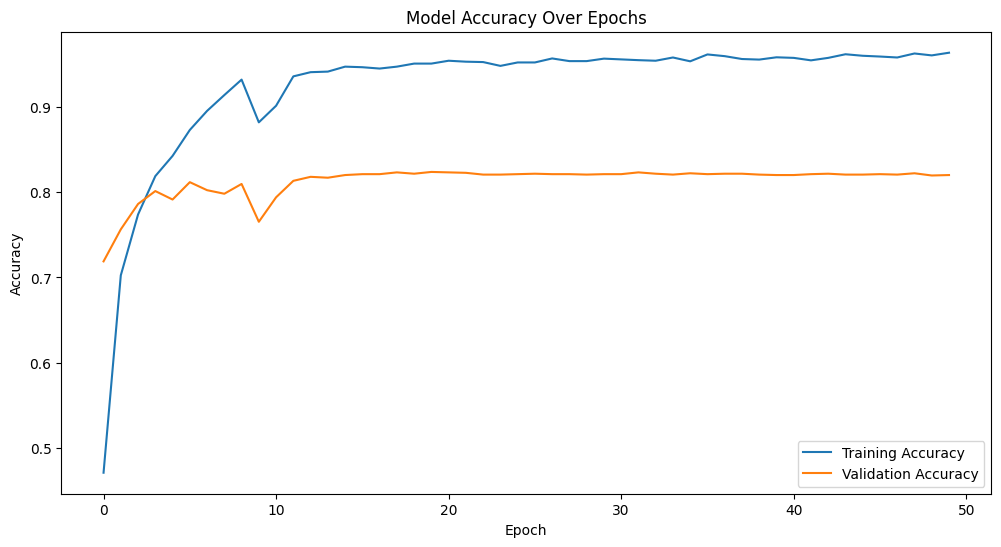

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Check and handle existing model
if os.path.isdir("./saved_model"):
    try:
        strr = input('Delete saved model? Y/N: ')
        if strr.lower() == 'y':
            print("Please delete the model manually if needed.")
        else:
            print('Using existing model.')
    except:
        pass

# Configure the dataset path
dataset_dir = "/content/drive/MyDrive/kvasir-dataset-v2/kvasir-dataset-v2"

# Define dataset categories and count files
def get_dataCategories(dataset_dir):
    import glob
    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg"))
            categories.append(np.array([folder_name, nbr_files]))
    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)
    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_dataCategories(dataset_dir)
df = pd.DataFrame({"categories": categories, "number of files": nbr_files})
print("Number of categories:", len(categories))
print(df)

# Create dataset with resizing
def create_dataset(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_resize_rgb = cv2.resize(img_array, (img_wid, img_high))
                X.append(img_resize_rgb)
                y.append(class_num)
            except Exception as e:
                pass
    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_high, 3)
    return X, y

img_wid, img_high = 100, 100
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# One-Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=0.1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=0.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=0.1)
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(X_test)

# Define the model using Functional API
input_tensor = Input(shape=(100, 100, 3))
base_model = VGG19(include_top=False, weights="imagenet", input_tensor=input_tensor)

# Freeze the layers of VGG19 if desired
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(y_train.shape[1], activation="softmax")(x)

# Combine base_model and new layers
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
batch_size = 128
epochs = 50
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

# Learning rate reduction callback
lrr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.01, patience=3, min_lr=1e-5)

# Train the model if it hasn't been trained and saved already
if not os.path.isfile("./saved_model/model.h5"):
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[lrr],
        verbose=1,
    )
    history_data = history.history
    np.save("model_history.npy", history_data)
    model.save("model.h5")
else:
    model = load_model("./saved_model/model.h5")
    history_data = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()

# ---- Retrieve Final Training and Validation Accuracy ----
train_accuracy = history_data['accuracy'][-1]  # Last training accuracy
val_accuracy = history_data['val_accuracy'][-1]  # Last validation accuracy

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

# ---- Evaluate on the Test Set ----
score = model.evaluate(X_test, y_test, verbose=0)
test_accuracy = score[1]  # Accuracy is the second value in the score array
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# ---- Optional Validation Set Evaluation ----
score_val = model.evaluate(x_val, y_val, verbose=0)
print("Validation Loss:", round(score_val[0], 3))
print("Validation Accuracy:", round(score_val[1] * 100, 2), "%")

# ---- Precision, Recall, and F1-Score for the Test Set ----
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_data['accuracy'], label="Training Accuracy")
plt.plot(history_data['val_accuracy'], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# # Plot Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(8, 6))
# ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories).plot()
# plt.title("Confusion Matrix")
# plt.show()

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_data['accuracy'], label="Training Accuracy")
plt.plot(history_data['val_accuracy'], label="Validation Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()